### Rifiniti Data Analysis Quiz 

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import gc

%matplotlib inline

Loading the data

In [2]:
df = pd.read_excel('Employee_Attributes_3-15-2018.xlsx' ) 


In [3]:
main = pd.read_excel('Activity Report 041318.xlsx', sheet_name = 0)

In [4]:
front  = pd.read_excel('Activity Report 041318.xlsx', sheet_name = 1)
exterior = pd.read_excel('Activity Report 041318.xlsx', sheet_name = 2)
interior  = pd.read_excel('Activity Report 041318.xlsx', sheet_name = 3)
lobby  = pd.read_excel('Activity Report 041318.xlsx', sheet_name = 4)
ld_dock_hallway = pd.read_excel('Activity Report 041318.xlsx', sheet_name = 5)
pedestrian  = pd.read_excel('Activity Report 041318.xlsx', sheet_name = 6)
rear  = pd.read_excel('Activity Report 041318.xlsx', sheet_name = 7)
left  = pd.read_excel('Activity Report 041318.xlsx', sheet_name = 8)
ld_dock  = pd.read_excel('Activity Report 041318.xlsx', sheet_name = 9)

In [5]:
df_concat = pd.concat([main, front, exterior, interior, lobby, ld_dock_hallway, pedestrian, rear, left, ld_dock]).reset_index()

### 1.1)  Assume that all entries and exits at H are captured by the sensor system, please first merge the two datasets. Column Employee ID contains unique identifiers of all visitors of building H. Feel free to express your concern with the data quality, if there is any. 

- lots of missing data

Data Cleaning

In [6]:
df_concat['ID'] = df_concat['Employee ID']

In [7]:
df_concat = df_concat.drop(columns = ['index', 'Employee ID'])

In [8]:
result = pd.merge(df_concat, 
                  df[['ID', 'Floor', 'Resource Type', 'Division', 'Room']], 
                    on = 'ID', 
                    how = 'left')

In [9]:
result.fillna('unknown', inplace=True)

In [10]:
result[pd.isnull(result).any(axis=1)]

,Date/Time,Door Name,ID,Floor,Resource Type,Division,Room


In [11]:
result.loc[(result['Resource Type'] == 'Contract Service Worker'), 'Floor'] = "001"

In [12]:
result.loc[result['Resource Type'] == 'Contract Service Worker', 'Resource Type'] = "Contractor"
result.loc[((result['ID'].str.contains('T')) &
            (result['Door Name'] != 'Rear Right Revolving Door.') & 
            (result['Door Name'] != 'Left Revolving Door.')), 'Resource Type'] = "Contractor"

In [13]:
#result.loc[((result['Resource Type'] == 'Contractor') & 
 #           (result['Door Name'] == 'Exterior Sensor Loading Dock Door.')), 'Division'] = "DEPT 12"

In [14]:
#result.loc[((result['Resource Type'] == 'Contractor') & 
       #     (result['Door Name'] == 'Loading Dock Hallway Door.')), 'Division'] = "DEPT 12"

In [15]:
result['Date/Time'] = pd.to_datetime(result['Date/Time'])
result.head()

,Date/Time,Door Name,ID,Floor,Resource Type,Division,Room
0,2018-03-29 00:12:53,Main Entrance Revolving Door.,T138294,unknown,Contractor,unknown,unknown
1,2018-03-29 05:04:40,Main Entrance Revolving Door.,T148589,001,Contractor,DEPT 12,
2,2018-03-29 05:29:30,Main Entrance Revolving Door.,135863,006,Employee,DEPT 2,0268
3,2018-03-29 05:30:44,Main Entrance Revolving Door.,106326,005,Employee,DEPT 2,0277
4,2018-03-29 05:31:49,Main Entrance Revolving Door.,134700,006,Employee,DEPT 2,0446


In [16]:
result = result[result['Date/Time'].dt.dayofweek < 5]

In [17]:
result['Date/Time'] = pd.to_datetime(result['Date/Time']).dt.date


#### Final Merged Data:

In [18]:
result.head()

,Date/Time,Door Name,ID,Floor,Resource Type,Division,Room
0,2018-03-29,Main Entrance Revolving Door.,T138294,unknown,Contractor,unknown,unknown
1,2018-03-29,Main Entrance Revolving Door.,T148589,001,Contractor,DEPT 12,
2,2018-03-29,Main Entrance Revolving Door.,135863,006,Employee,DEPT 2,0268
3,2018-03-29,Main Entrance Revolving Door.,106326,005,Employee,DEPT 2,0277
4,2018-03-29,Main Entrance Revolving Door.,134700,006,Employee,DEPT 2,0446


### 1.2)  Calculate the number of people arriving at H per day. Then further break down the metric by ‘Resource Type’ and ‘Division’ attributes. Make a visualization of this metric using your tool of choice. 

In [19]:
by_id = result.groupby(['ID']).count().reset_index()

In [20]:
by_id = by_id.drop(columns = ['Date/Time', 'Floor', 'Resource Type', 'Division' , 'Room'])

In [21]:
by_id.describe()

,Door Name
count,2138.000000
mean,9.922357
std,10.260097
min,1.000000
25%,2.000000
50%,7.000000
75%,16.000000
max,192.000000


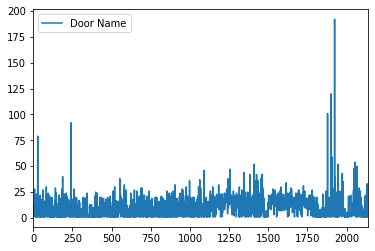

In [22]:
by_id.plot()

#### We have outliers; An outlier is typically more than 3 standard deviations above/below the mean; In our case; the outliers are:

In [23]:
by_id[by_id['Door Name'] > 40]

,ID,Door Name
28,105528,79
241,116239,92
1089,137087,46
1255,138338,47
1343,138598,44
1382,138779,42
1410,138862,52
1425,138953,42
1460,139180,42
1878,T125140,101


#### The number of unique id visit per day:

In [24]:
by_day = result.groupby(['Date/Time'])['ID'].nunique().reset_index()

In [25]:
by_day 

,Date/Time,ID
0,2018-03-29,1131
1,2018-03-30,896
2,2018-04-02,1111
3,2018-04-03,1251
4,2018-04-04,1193
5,2018-04-05,1171
6,2018-04-06,1022
7,2018-04-09,1162
8,2018-04-10,1195


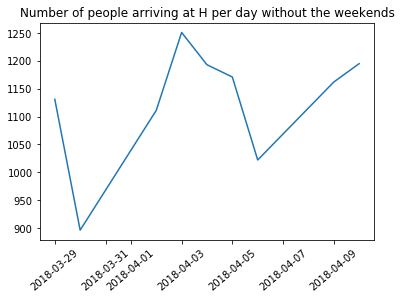

In [26]:
plt.xticks(rotation = 40)
plt.title('Number of people arriving at H per day without the weekends')
plt.plot(by_day['Date/Time'], by_day['ID'])

#### Number of unique visits per resource type per day:

In [27]:
by_day_further_res = result.groupby(['Date/Time', 'Resource Type'])['ID'].nunique().reset_index()

In [28]:
by_day_further_res.head()

,Date/Time,Resource Type,ID
0,2018-03-29,Contractor,81
1,2018-03-29,Employee,794
2,2018-03-29,Vendor Rep,1
3,2018-03-29,unknown,277
4,2018-03-30,Contractor,56


#### Number of unique visits per division type per day:

In [29]:
by_day_further_division = result.groupby(['Date/Time', 'Division'])['ID'].nunique().reset_index()

In [30]:
by_day_further_division.head()

,Date/Time,Division,ID
0,2018-03-29,DEPT 1,9
1,2018-03-29,DEPT 10,1
2,2018-03-29,DEPT 12,6
3,2018-03-29,DEPT 2,799
4,2018-03-29,DEPT 5,6


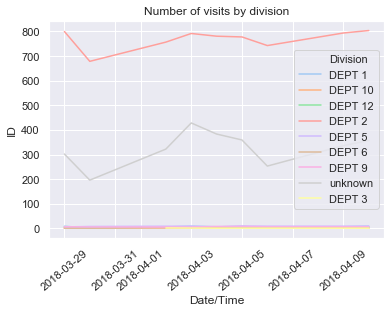

In [31]:
sns.set(style="darkgrid")

g = sns.lineplot(x="Date/Time", y="ID", hue = 'Division', data= by_day_further_division,
                    palette="pastel", ci=None)
sns.set(rc={'figure.figsize':(11.7,8.27)})
#g.despine(left=True)
#g.set_ylabels('Number of visits')
#g.set_xlabels("Date")
plt.xticks(rotation = 40)
plt.title('Number of visits by division')

plt.show()

In [32]:
by_day_further = result.groupby(['Date/Time', 'Resource Type', 'Division'])['ID'].nunique().reset_index()

In [33]:
by_day_further.head()

,Date/Time,Resource Type,Division,ID
0,2018-03-29,Contractor,DEPT 12,6
1,2018-03-29,Contractor,DEPT 2,22
2,2018-03-29,Contractor,DEPT 9,6
3,2018-03-29,Contractor,unknown,47
4,2018-03-29,Employee,DEPT 1,9


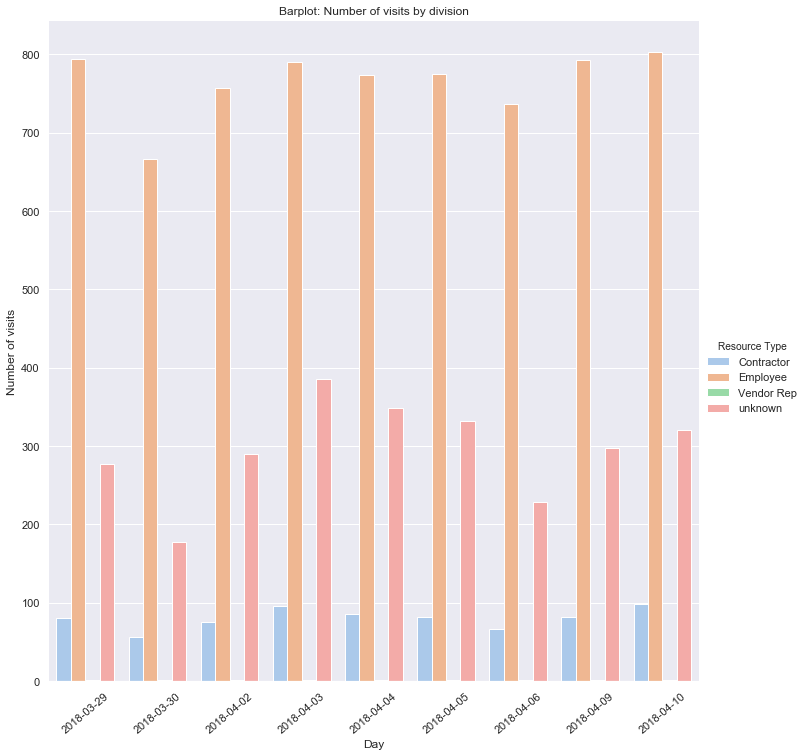

In [40]:
sns.set(style="darkgrid")

g = sns.factorplot(x="Date/Time", y="ID", hue = 'Resource Type', data= by_day_further_res,
                   size=10, kind="bar", palette="pastel", ci=None)
g.despine(left=True)
g.set_ylabels('Number of visits')
g.set_xlabels("Day")
plt.xticks(rotation = 40)
plt.title('Barplot: Number of visits by division')
plt.show()

### 1.3)  Now look at employees who are assigned to H, propose a method to categorize them based on their visits to H. 

The employees can be categorised by:
- resource type - employees or contractors
- frequent/non-frequent visitors of building H - more than 1 standard dev of the mean is a frequent visitor
- by division - Dep 2 (most employees belong to this department) and others


### 2. Merge the badge data with seat assignment data 


merged_tables = pd.merge(badge_swipe, 
                  badge_assignment, 
                    on = 'badge_id', 
                    how = 'left')

### 2.1)  Why do we need to use seat assignment (hr) information? If a client does not send their hr files for privacy reason, could you provide a method to estimate the seat assignment only based on badge data? (You can provide python implementation using the badge dataset from ’Activity Report 041318.xlsx’) 

In [35]:
dff = pd.DataFrame()

In [36]:
dff['Date/Time'] =result['Date/Time'].astype('category').cat.codes
dff['Door Name'] =result['Door Name'].astype('category').cat.codes
dff['ID'] =result['ID'].astype('category').cat.codes
dff['Floor'] = result['Floor'].astype('category').cat.codes
dff['Resource Type'] = result['Resource Type'].astype('category').cat.codes
dff['Division'] = result['Division'].astype('category').cat.codes
dff['Room'] = result['Room'].astype('category').cat.codes

In [37]:
dff.corr(method='pearson')


,Date/Time,Door Name,ID,Floor,Resource Type,Division,Room
Date/Time,1.000000,-0.007726,0.001356,0.027344,0.022780,0.031731,0.020350
Door Name,-0.007726,1.000000,-0.076447,-0.067064,0.115214,-0.073643,-0.041414
ID,0.001356,-0.076447,1.000000,-0.028224,-0.280414,0.097170,0.010345
Floor,0.027344,-0.067064,-0.028224,1.000000,0.469498,0.711324,0.494921
Resource Type,0.022780,0.115214,-0.280414,0.469498,1.000000,0.601525,0.400768
Division,0.031731,-0.073643,0.097170,0.711324,0.601525,1.000000,0.593644
Room,0.020350,-0.041414,0.010345,0.494921,0.400768,0.593644,1.000000


In [38]:
#result.to_excel(r'Downloads\File Nameff.xlsx') 

No strong correlation between any of the features in the badge data vs employee data;
That means that we can predict only limited information based on the badge data:
- If id starts with 'T'; the Resource Type is either a ' Contractor' or a 'Vendor Rep'


If we have more information about the location of those doors in relation to the rooms/floors as well as the event type(enter or exit), we can assume whete the employee is located based on the time difference between enter and exit and the exact door he/she enters the building from.

### 2.2)  Give an example, Client A normally sends us their badge data weekly, and seat assignment data monthly. 
A tells us that they only offer us the updated assignment data every month. For example, if one employee is reassigned to another department or they have new employees coming this month, they will update us, and for those people without changing assignment will not appear in this month’s seat assignment table any more. They keep the data schema consistent, so you do not need to worry about concatenating any historical data when you need to track backwards. As seen from the client’s datasets’ schema, could you provide a sql query/ python implementation to merge them? Hint: (Please feel free to add any new columns if you think is necessary.) 


ALTER TABLE Employee_Att_template
  ADD timestampcol timestamp


Select * 
from Employee_Att_this_month
Union 
Select * 
from Employee_att_prev_month
Where timestampcol < DATEADD(Day,-30,GETDATE())
